# Aulinha - Pytorch
Grupo Turing - NLP

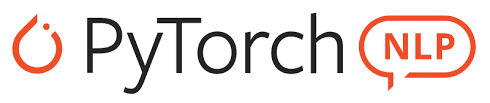

## Torchtext
`tochtext` é um pacote do Pytorch que possui alguns datasets populares e ferramentas de pré-processamento de dados para NLP.

## torchtext.datasets

Alguns datasets disponíveis no `torchtext` são: [IMDb](https://pytorch.org/text/stable/datasets.html#imdb) (Análise de Sentimentos), [WikiText-2](https://pytorch.org/text/stable/datasets.html#wikitext-2) (LM), [YahooAnswers](https://pytorch.org/text/stable/datasets.html#yahooanswers) (Classificação), [AmazonReviewPolarity](https://pytorch.org/text/stable/datasets.html#amazonreviewpolarity) (Classif.) e [AmazonReviewFull](https://pytorch.org/text/stable/datasets.html#amazonreviewfull) (Classif.). Você pode ver todos os datsets disponíveis [aqui](https://pytorch.org/text/stable/datasets.html).

Como exemplo, vou usar o [AG_NEWS](https://pytorch.org/text/stable/datasets.html#ag-news), que possui notícias classificadas como "world", "sports", "business" e "science".

In [ ]:
!pip install torchtext==0.4

In [ ]:
import torch
import torchtext
from torchtext.datasets import text_classification
import os

NGRAMS = 2
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ag_news_csv.tar.gz: 11.8MB [00:00, 109MB/s]
120000lines [00:09, 13068.34lines/s]
120000lines [00:19, 6089.05lines/s]
7600lines [00:01, 6637.81lines/s]


Podemos fazer o load dos datasets do `TextClassification` separando os textos em ngramas.
No caso, usamos `ngrams = 2`, ou seja, bigramas.


## Classificador

Vamos fazer uma rede simples para usar como exemplo, com uma camada de Embedding e uma camada linear (aplica uma transformação linear *y = xA^T + b*).

### Definindo o modelo

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

Instanciado:

In [ ]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

Gerando batches:

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

Obs: `torch.Tensor.cumsum` retorna a soma cumulativa dos elementos da dimensão dim do tensor:

In [ ]:
torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

tensor([1., 3., 6.])

Definindo funções de treino e teste:

In [ ]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

### Rodando

In [ ]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 29 seconds
	Loss: 0.0262(train)	|	Acc: 84.6%(train)
	Loss: 0.0001(valid)	|	Acc: 89.5%(valid)
Epoch: 2  | time in 0 minutes, 28 seconds
	Loss: 0.0118(train)	|	Acc: 93.7%(train)
	Loss: 0.0001(valid)	|	Acc: 90.8%(valid)
Epoch: 3  | time in 0 minutes, 28 seconds
	Loss: 0.0068(train)	|	Acc: 96.5%(train)
	Loss: 0.0001(valid)	|	Acc: 91.3%(valid)
Epoch: 4  | time in 0 minutes, 28 seconds
	Loss: 0.0038(train)	|	Acc: 98.1%(train)
	Loss: 0.0001(valid)	|	Acc: 91.3%(valid)
Epoch: 5  | time in 0 minutes, 28 seconds
	Loss: 0.0022(train)	|	Acc: 99.0%(train)
	Loss: 0.0001(valid)	|	Acc: 91.5%(valid)


### Avaliação

In [ ]:
print('Resultados:')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Resultados:
	Loss: 0.0003(test)	|	Acc: 90.9%(test)


## torchtext.data

Vamos testar o modelo em uma nova notícia usando o `get_tokenizer` e o `ngrams_iterator` do `torchtext.data.utils`.

In [ ]:
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

O `get_tokenizer` gera um tokenizador. O torchtext possui um tokenizador para inglês:

In [ ]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer("Ines Montani is hiding three one-armed bandits!")
print(tokens)

['ines', 'montani', 'is', 'hiding', 'three', 'one-armed', 'bandits', '!']


Mas também dá para usá-lo com tokenizadores de outras bibliotecas para usar com outras línguas:

In [ ]:
!python -m spacy download pt

In [ ]:
pt_tokenizer = get_tokenizer('spacy', language='pt')
tokens = pt_tokenizer("Ines Montani está escondendo três caça níqueis!")
print(tokens)

['Ines', 'Montani', 'está', 'escondendo', 'três', 'caça', 'níqueis', '!']


O `ngrams_iterator` retorna um iterador que gera os tokens e seus ngramas:

In [ ]:
token_list = ['olha', 'eu', 'aqui']
print(list(ngrams_iterator(token_list, 2)))

['olha', 'eu', 'aqui', 'olha eu', 'eu aqui']


### Usando o modelo para classificar uma nova notícia:

In [ ]:
import re

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

This is a Sports news
